# Analyze classifier metrics

Here we analyze the classifier metrics computed in notebook #1. We examine:

- Correlation between different metrics
- Class imbalance in ctrl and allele classifiers
- Overall cell count in ctrl and allele classifiers
- AUROC distribution in ctrl and allele classifiers
- Filter alleles based on class imbalance
- Compare metrics across batches
- Compare metrics across batches after filtering for class imbalance

In [1]:
# imports
import matplotlib.pyplot as plt
import plotnine as plotnine
import polars as pl
import seaborn as sns

In [2]:
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent_updatedmeta"
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")

## Correlation between metrics

<Figure size 1000x800 with 0 Axes>

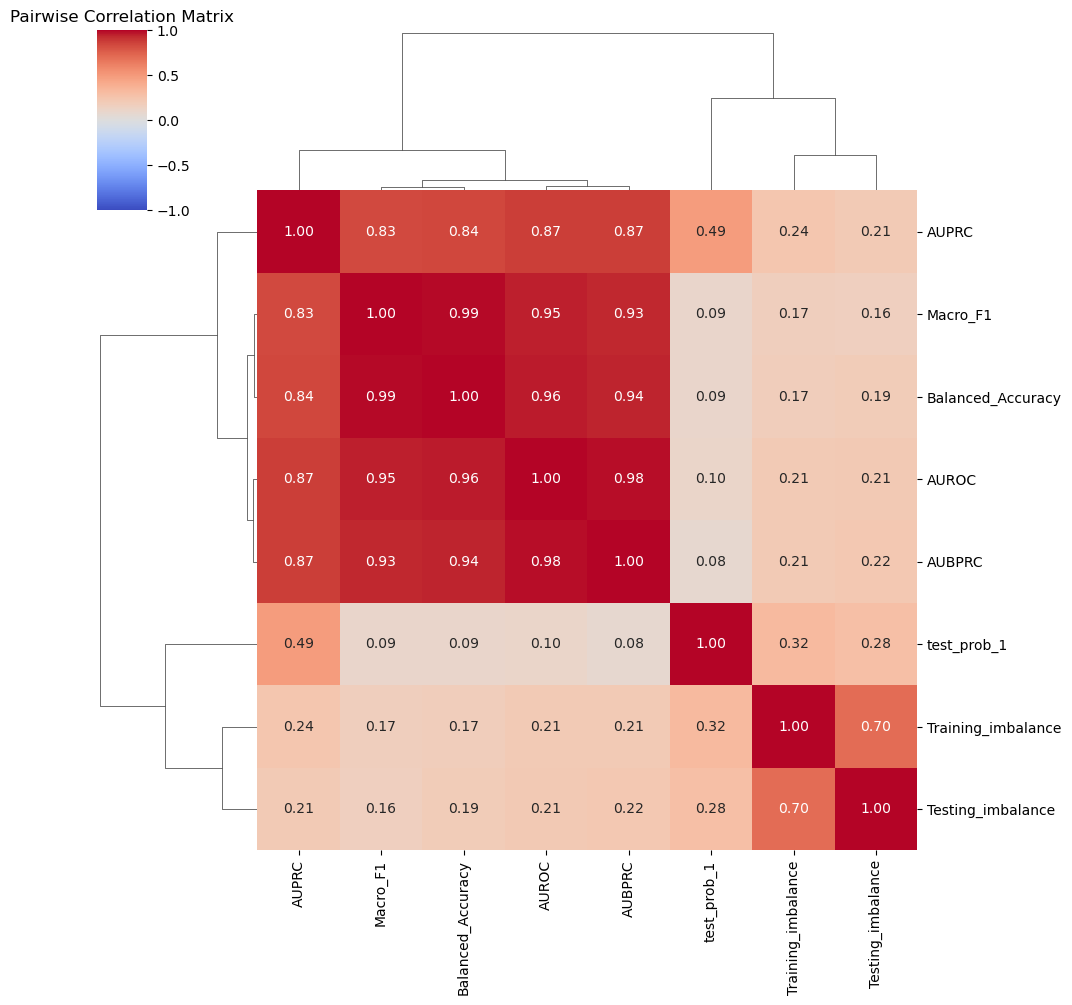

In [3]:
# Analyze pairwise correlation between metrics and test set imbalance
metrics_corr = (
    metrics_df.select([
        "AUROC",
        "AUPRC",
        "AUBPRC",
        "Macro_F1",
        "Balanced_Accuracy",
        "test_prob_1",
        "Training_imbalance",
        "Testing_imbalance",
    ])
    .to_pandas()
    .corr()
)

plt.figure(figsize=(10, 8))
sns.clustermap(metrics_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Pairwise Correlation Matrix")
plt.show()

## Training data class imbalance between controls and alleles

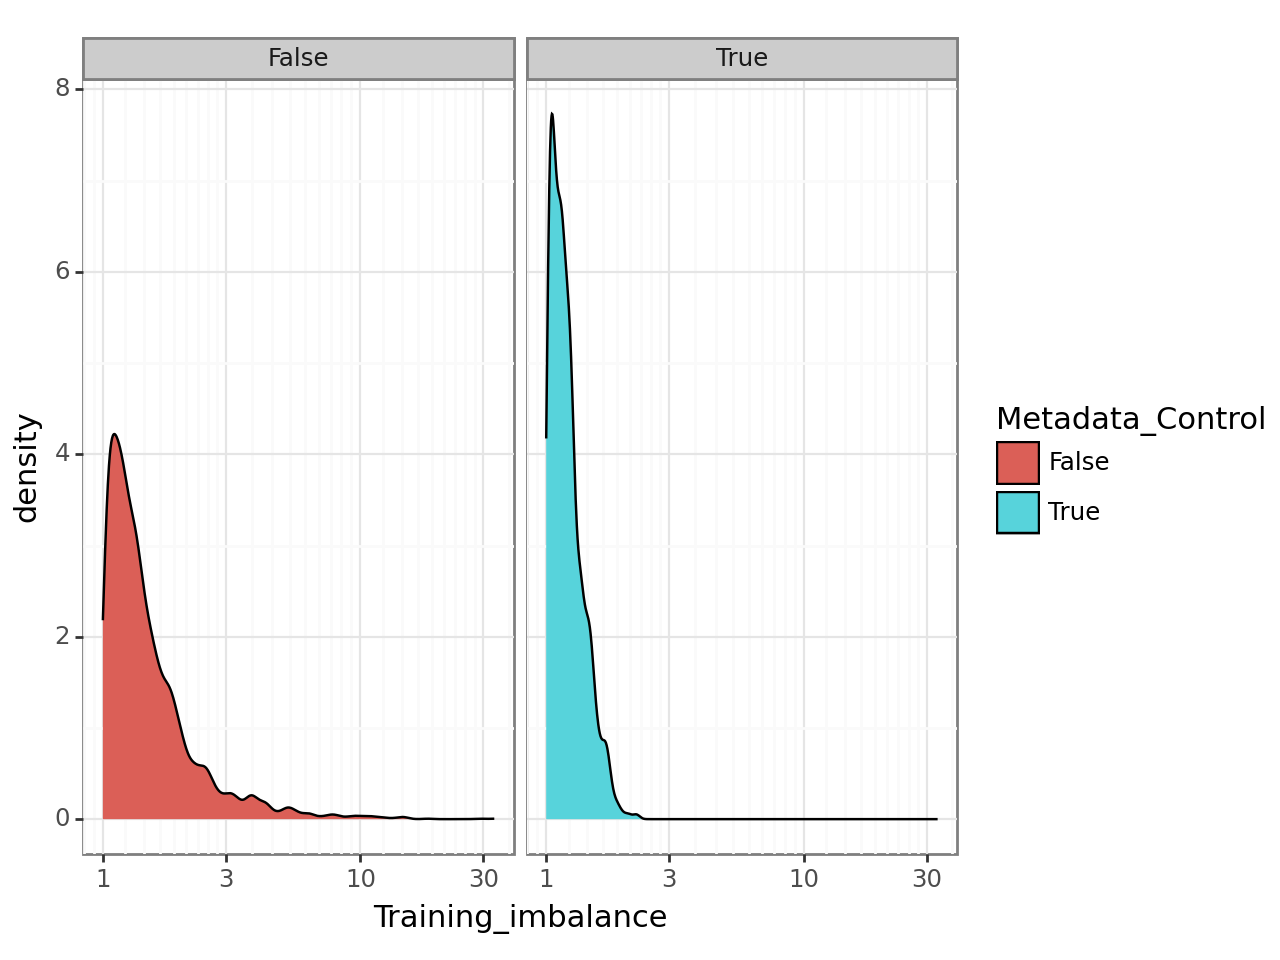

<Figure Size: (640 x 480)>

In [4]:
from plotnine import aes, facet_wrap, geom_density, ggplot, scale_x_log10, theme_bw

(
    ggplot(metrics_df, aes(x="Training_imbalance", fill="Metadata_Control"))
    + geom_density()
    + facet_wrap("Metadata_Control")
    + scale_x_log10()
    + theme_bw()
)

# This plot shows that in the training data, the controls (blue) are far more balanced than the WT-VAR (pink).
# To really prove that this is actual impact of density on features and not simply training class imbalance, I could downsample before training
# If the relationships hold, then we should still see the correlation between well cell count and classifier metrics.

In [5]:
metrics_df = metrics_df.with_columns(
    pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
    .then(pl.lit("localization"))
    .otherwise(pl.lit("morphology"))
    .alias("Classifier_type"),
    pl.when(pl.col("Full_Classifier_ID").str.contains("B7A"))
    .then(pl.lit("batch7"))
    .otherwise(pl.lit("batch8"))
    .alias("Batch"),
    pl.col("Plate").str.slice(13, 7).str.replace("R.*_", "").alias("Allele_set"),
)

## Cell count in control vs. allele classifiers

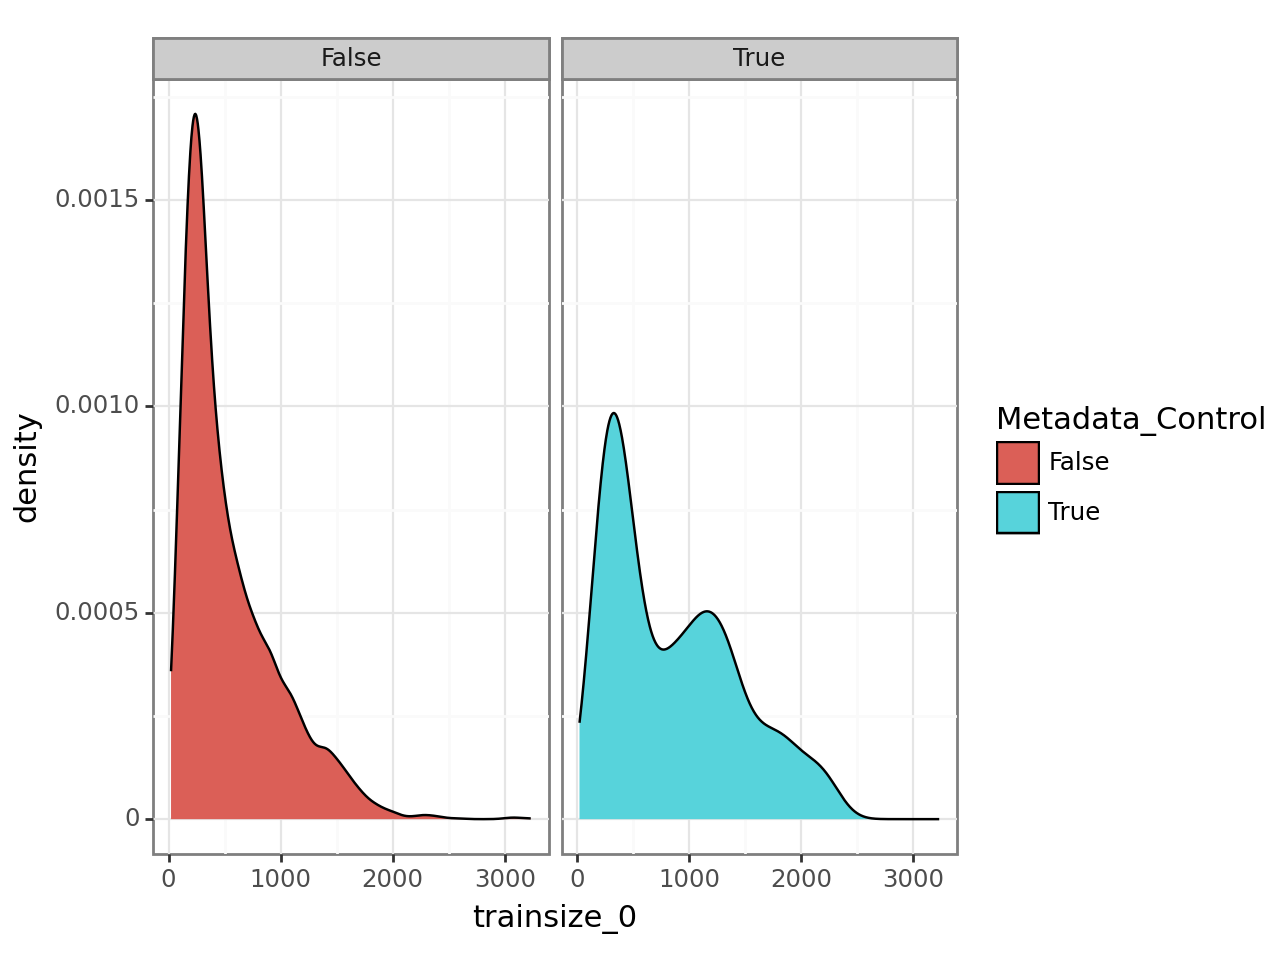

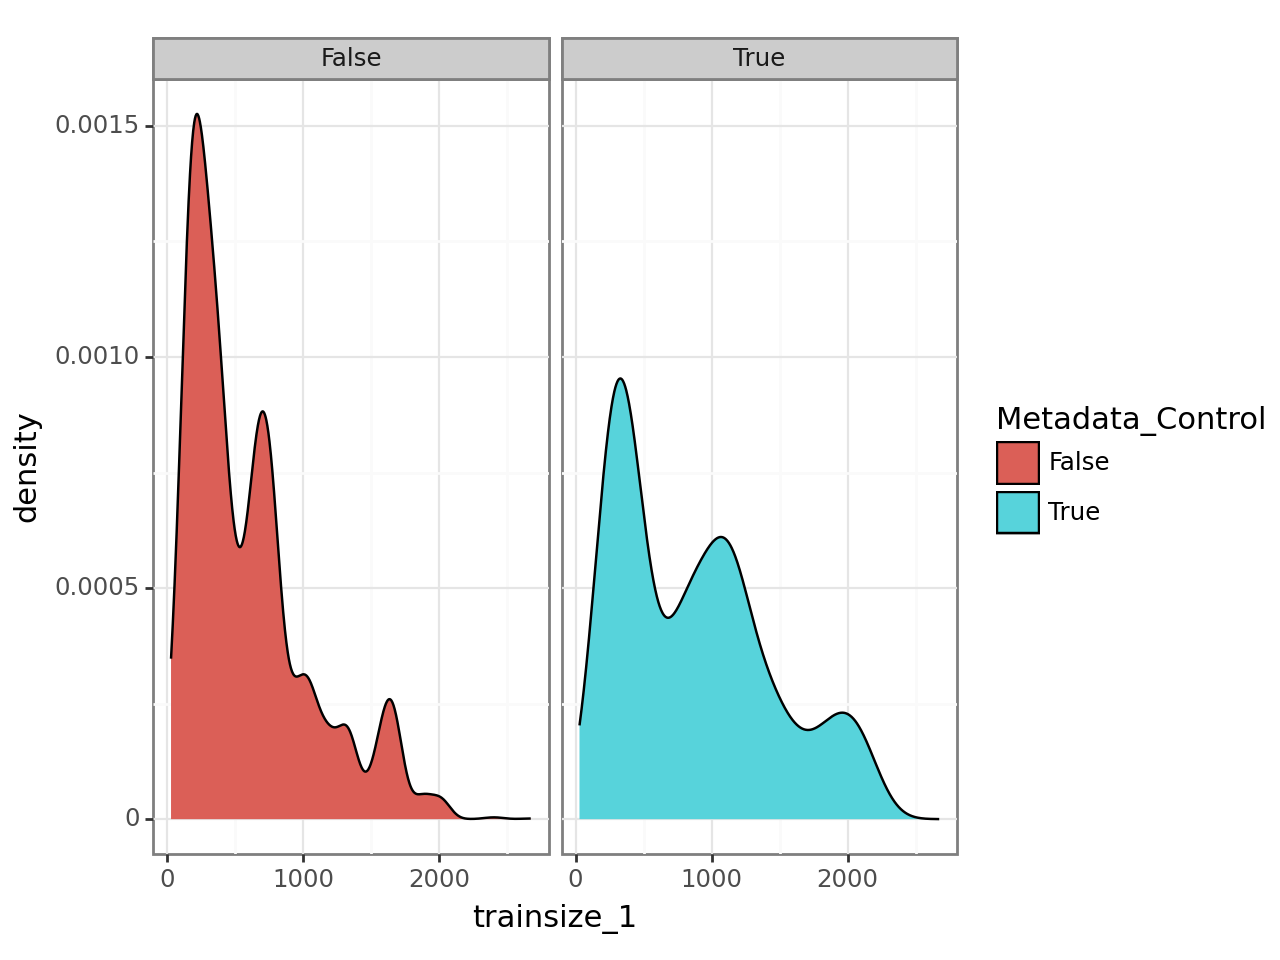

In [6]:
# Here we see that the distribution of training cell count is quite comparable between the WT-VAR and CTRL-CTRL pairs

from plotnine import aes, facet_wrap, geom_density, ggplot, theme_bw

plot1 = (
    ggplot(
        metrics_df.filter(pl.col("Classifier_type") == "localization"),
        aes(x="trainsize_0", fill="Metadata_Control"),
    )
    + geom_density()
    + facet_wrap("Metadata_Control")
    + theme_bw()
)
print(plot1)

plot2 = (
    ggplot(
        metrics_df.filter(pl.col("Classifier_type") == "localization"),
        aes(x="trainsize_1", fill="Metadata_Control"),
    )
    + geom_density()
    + facet_wrap("Metadata_Control")
    + theme_bw()
)
print(plot2)

## AUROC distribution in ctrl vs. allele classifiers

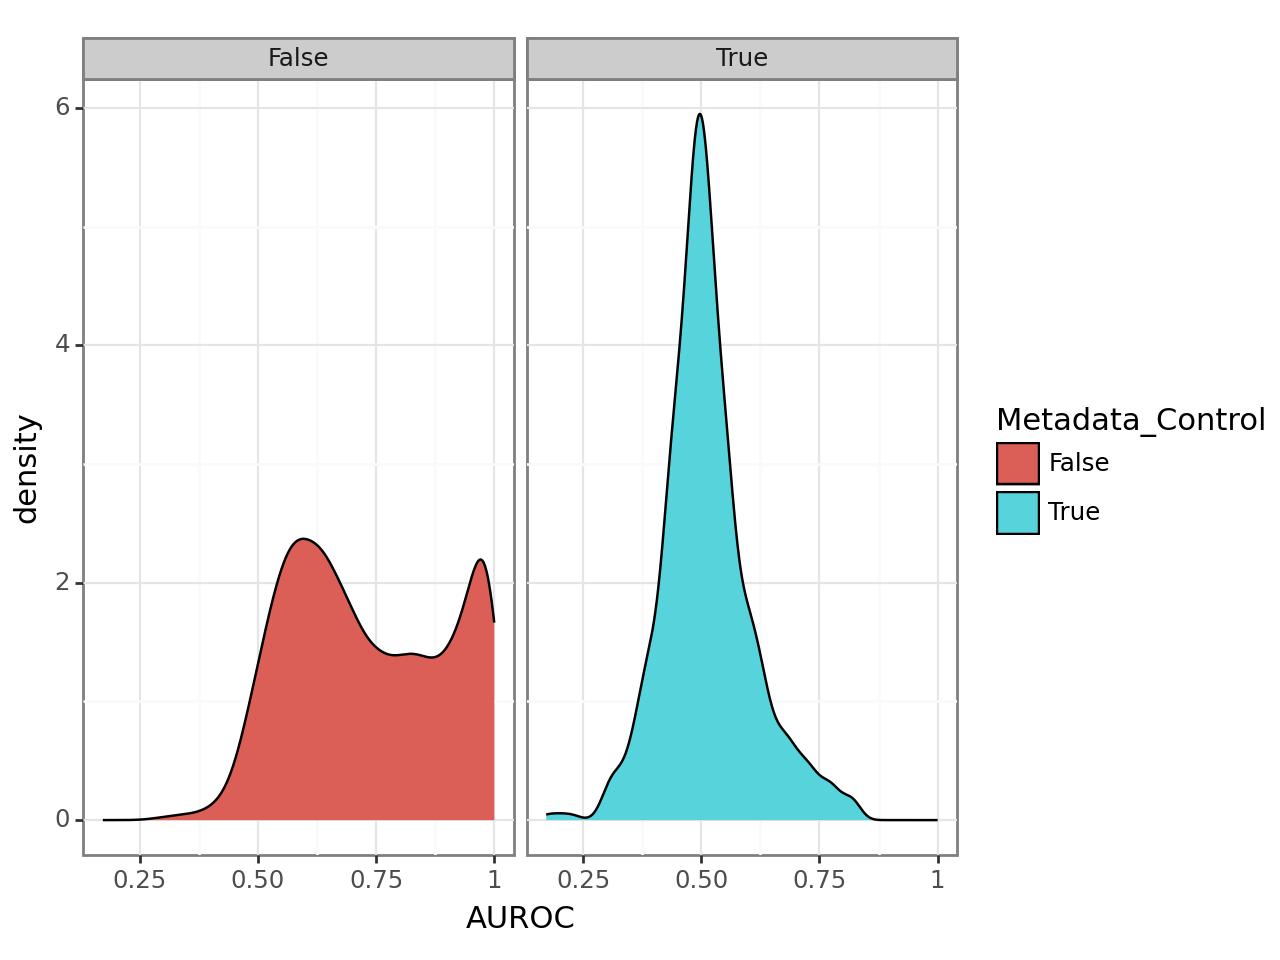

<Figure Size: (640 x 480)>

In [7]:
from plotnine import aes, facet_wrap, geom_density, ggplot, theme_bw

(
    ggplot(
        metrics_df.filter(pl.col("Classifier_type") == "localization"),
        aes(x="AUROC", fill="Metadata_Control"),
    )
    + geom_density()
    + facet_wrap("Metadata_Control")
    + theme_bw()
)

## Count number of alleles after filtering classifiers by class imbalance

In [8]:
imbalance_thresh = 10

print(metrics_df.shape)
print(metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).shape)

print(len(metrics_df.select("allele_0").to_series().unique().to_list()))
print(
    len(
        metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh)
        .select("allele_0")
        .to_series()
        .unique()
        .to_list()
    )
)

(9742, 26)
(9698, 26)
604
602


## Compare metrics across batch7 and batch8

Next, look at metrics across replicates within each batch, and also across batches (compare metrics aggregated across replicates). 

In [9]:
metrics_summary = (
    metrics_df.select([
        "AUROC",
        "AUPRC",
        "AUBPRC",
        "Macro_F1",
        "Balanced_Accuracy",
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .group_by([
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .agg([
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .mean()
        .suffix("_mean"),
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .median()
        .suffix("_median"),
    ])
    .with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))
)


/tmp/ipykernel_6990/3677783869.py:22: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.
/tmp/ipykernel_6990/3677783869.py:32: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_density.py:166: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_density.py:171: PlotnineWarning: Groups with fewer than 2 data points have been removed.
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_density.py:166: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_density.py:171: PlotnineWarning: Groups with fewer than 2 data points have been removed.


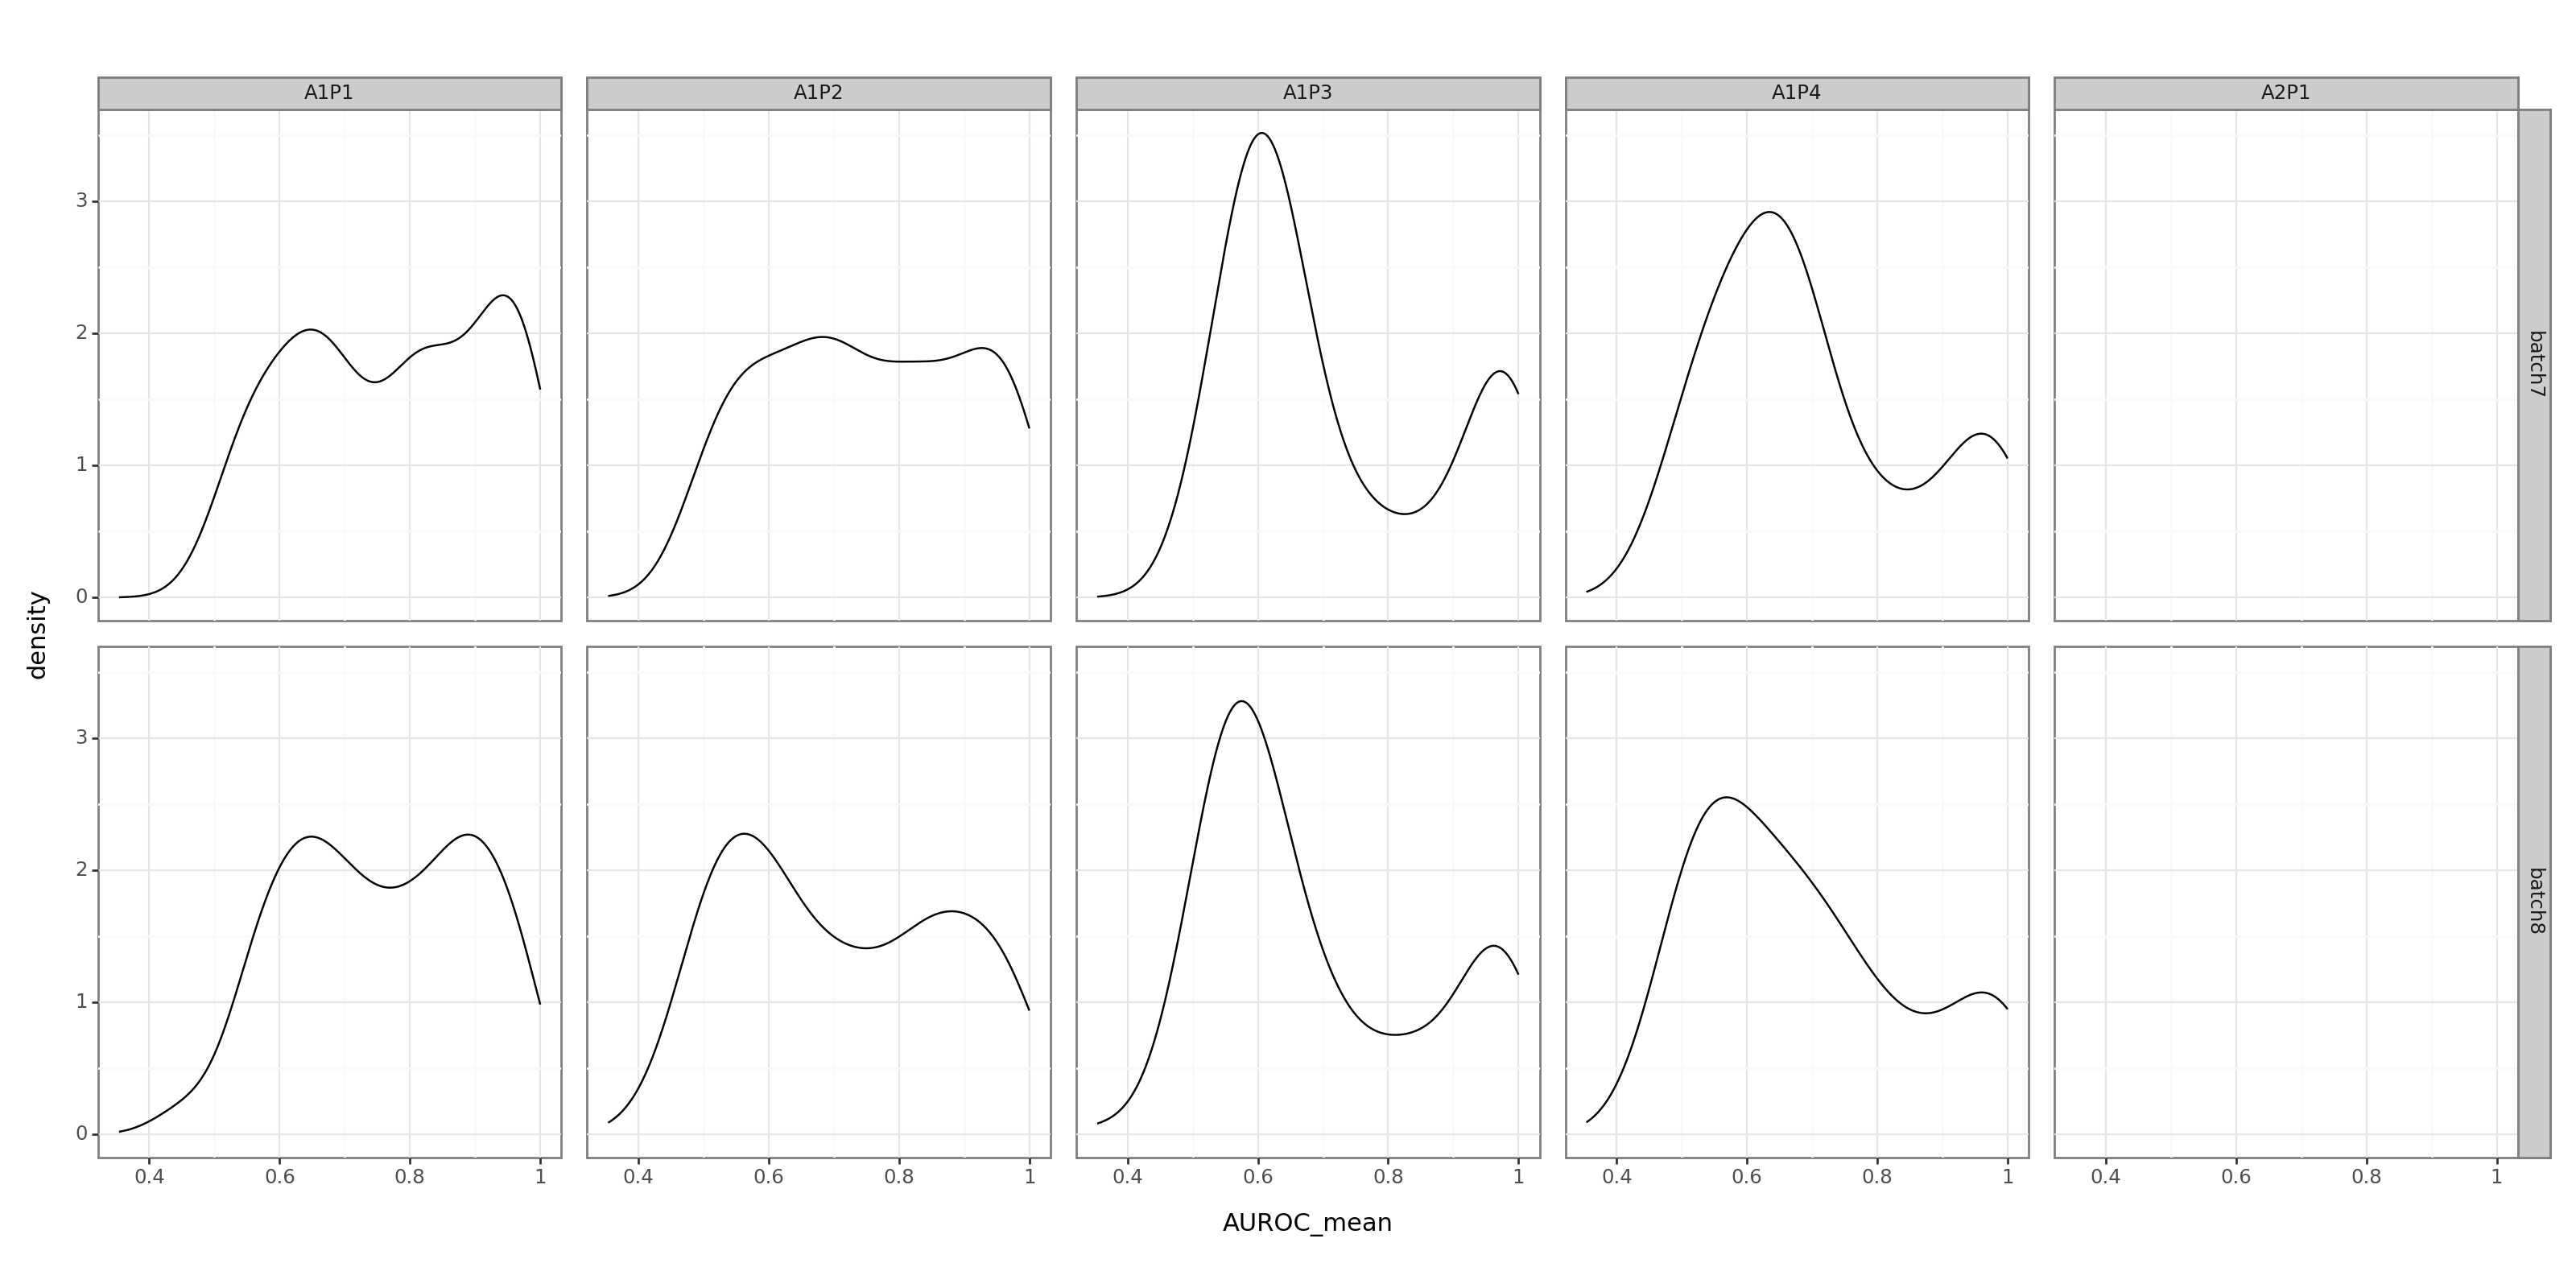

In [10]:
# Compare across allele sets
from plotnine import aes, facet_grid, geom_point, ggplot, theme_bw

plotnine.options.figure_size = (16, 8)
plot1 = (
    ggplot(
        metrics_summary.filter(
            (pl.col("Metadata_Control") == "false")
            & (pl.col("Classifier_type") == "localization")
        ),
        aes(x="AUROC_mean"),
    )
    + geom_density()
    + theme_bw()
    + facet_grid("Batch ~ Allele_set")
)
print(plot1)

In [11]:
# pivot to have separate column for batch 7 and batch 8
metrics_summary = metrics_summary.melt(
    id_vars=["Classifier_type", "Metadata_Control", "allele_0", "Batch", "Allele_set"],
    value_vars=[
        col
        for col in metrics_summary.columns
        if col
        not in [
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ]
    ],
    value_name="Value",
    variable_name="Metric",
).pivot(
    index=["Classifier_type", "Metadata_Control", "allele_0", "Metric", "Allele_set"],
    columns="Batch",
    values="Value",
)

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 580 rows containing missing values.


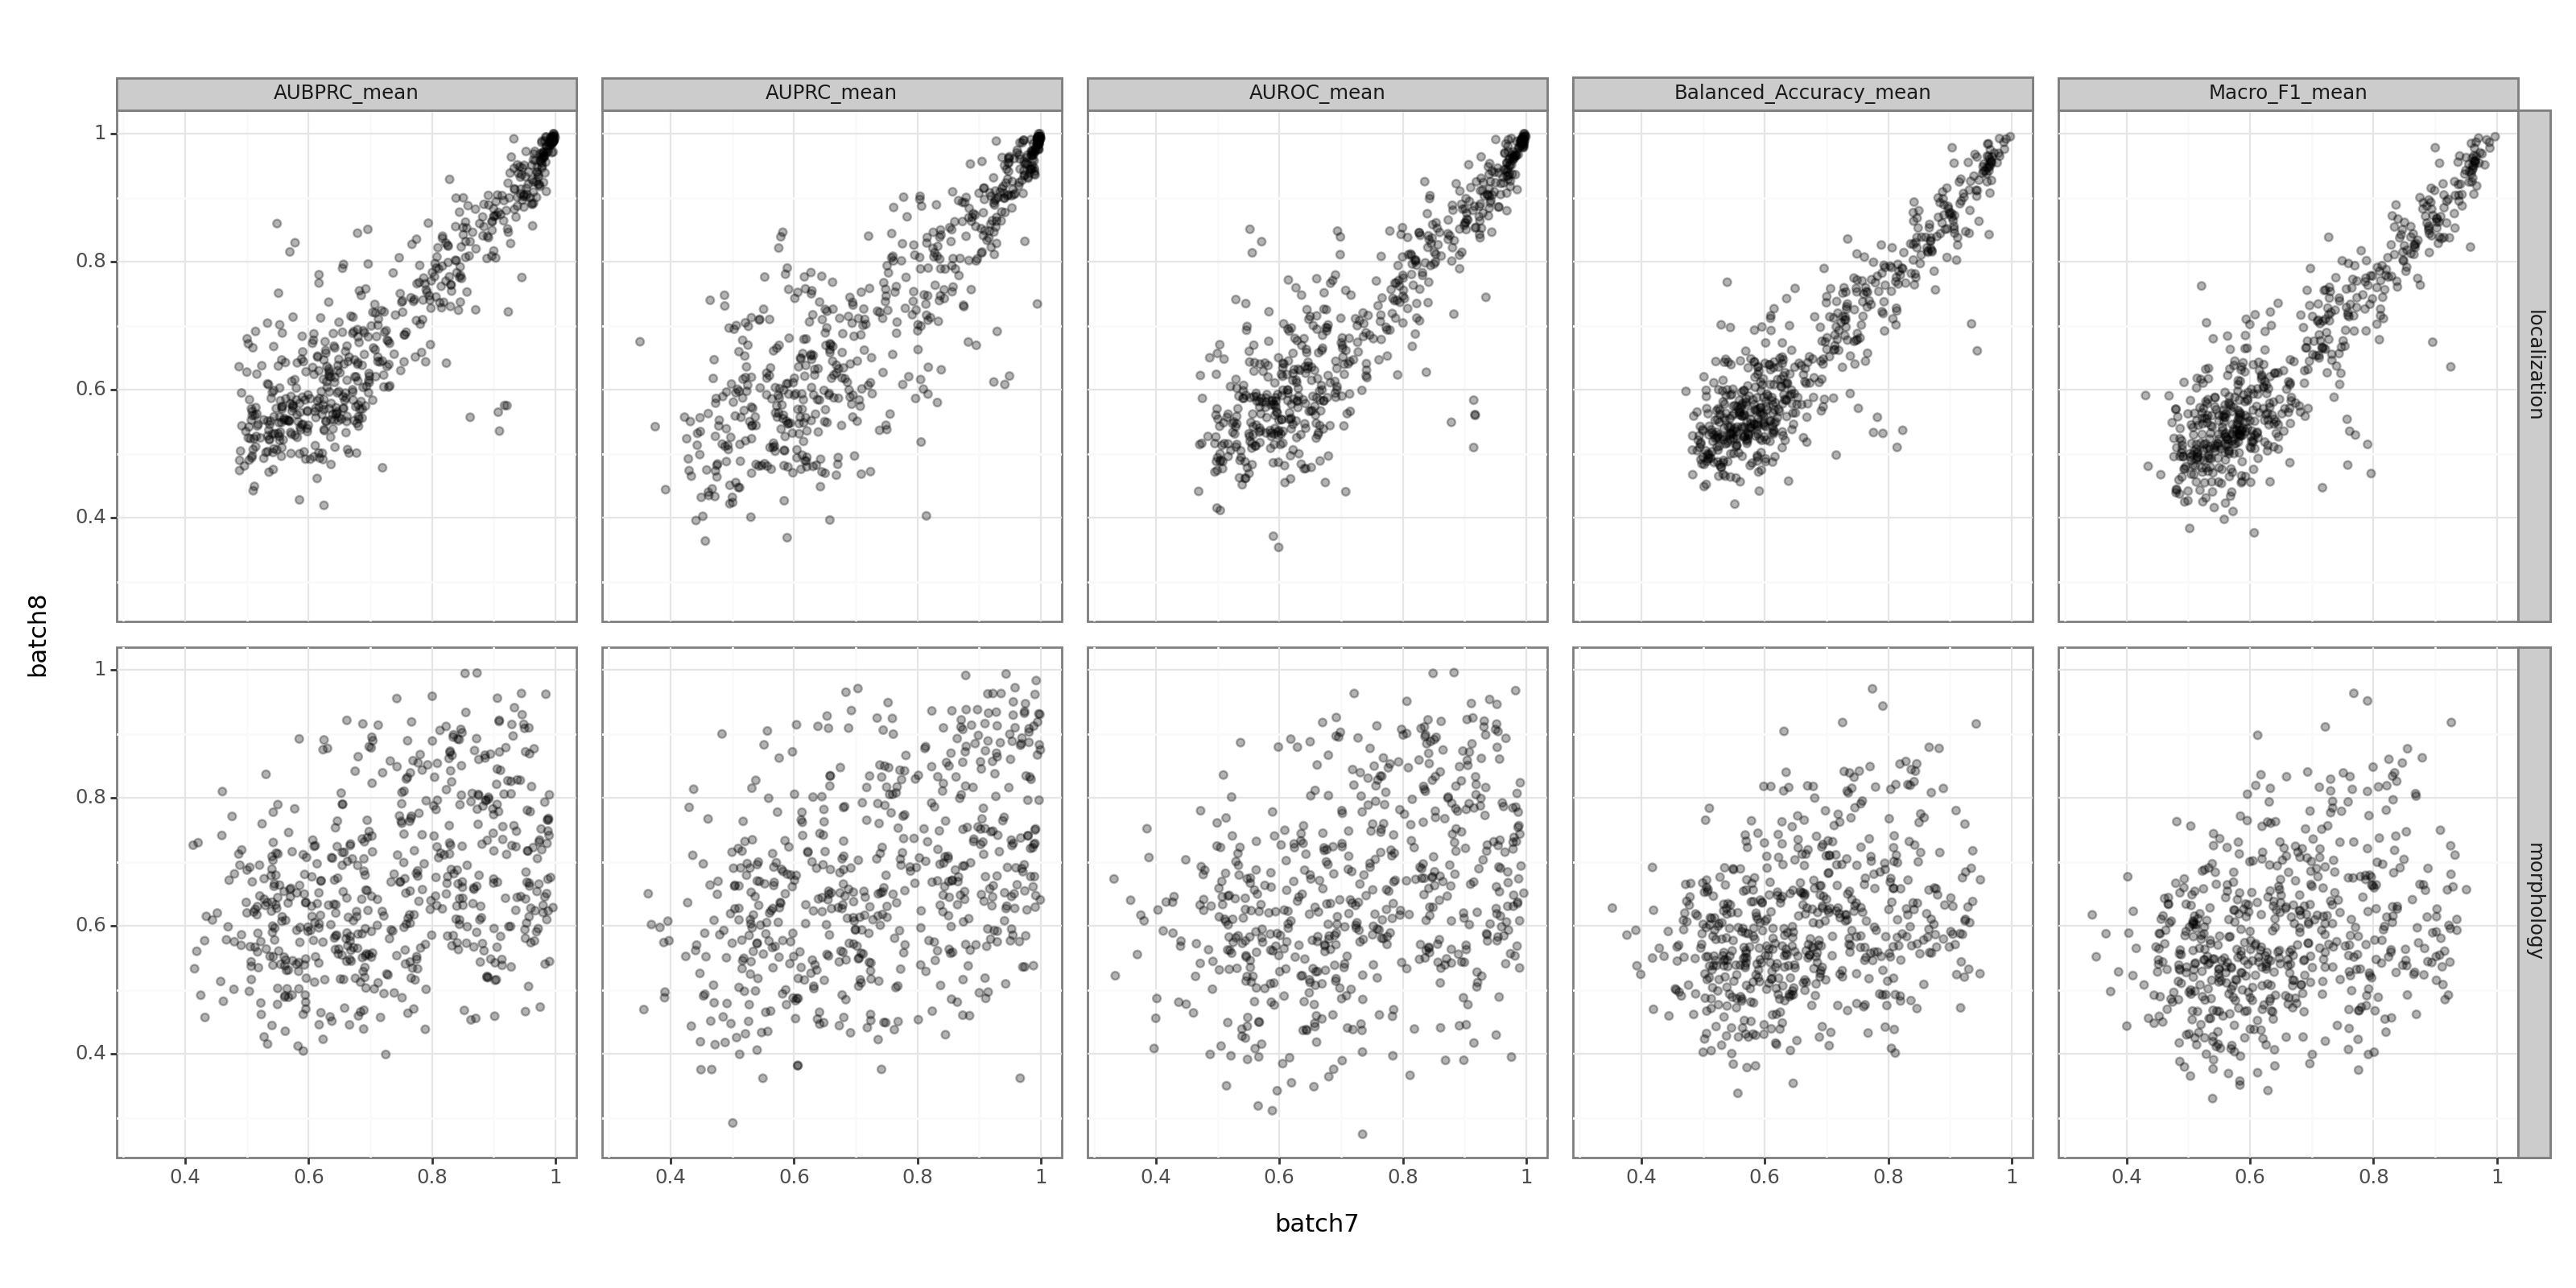

<Figure Size: (1600 x 800)>

In [12]:
plotnine.options.figure_size = (16, 8)
(
    ggplot(
        metrics_summary.filter(pl.col("Metric").str.contains("mean")),
        aes(x="batch7", y="batch8"),
    )
    + geom_point(alpha=0.3)
    + theme_bw()
    + facet_grid("Classifier_type ~ Metric", "free")
)

## Compare metrics across batches after filtering for class imbalance

In [13]:
# try after filtering based on imbalance
imbalance_thresh = 10
metrics_summary = (
    metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh)
    .select([
        "AUROC",
        "AUPRC",
        "AUBPRC",
        "Macro_F1",
        "Balanced_Accuracy",
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .group_by([
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Batch",
        "Allele_set",
    ])
    .agg([
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .mean()
        .suffix("_mean"),
        pl.all()
        .exclude([
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ])
        .median()
        .suffix("_median"),
    ])
    .with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))
)

metrics_summary = metrics_summary.melt(
    id_vars=["Classifier_type", "Metadata_Control", "allele_0", "Batch", "Allele_set"],
    value_vars=[
        col
        for col in metrics_summary.columns
        if col
        not in [
            "Classifier_type",
            "Metadata_Control",
            "allele_0",
            "Batch",
            "Allele_set",
        ]
    ],
    value_name="Value",
    variable_name="Metric",
).pivot(
    index=[
        "Classifier_type",
        "Metadata_Control",
        "allele_0",
        "Metric",
        "Allele_set",
    ],  # Preserving these columns as indexes
    columns="Batch",
    values="Value",
)


/tmp/ipykernel_6990/209164296.py:25: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.
/tmp/ipykernel_6990/209164296.py:35: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 590 rows containing missing values.


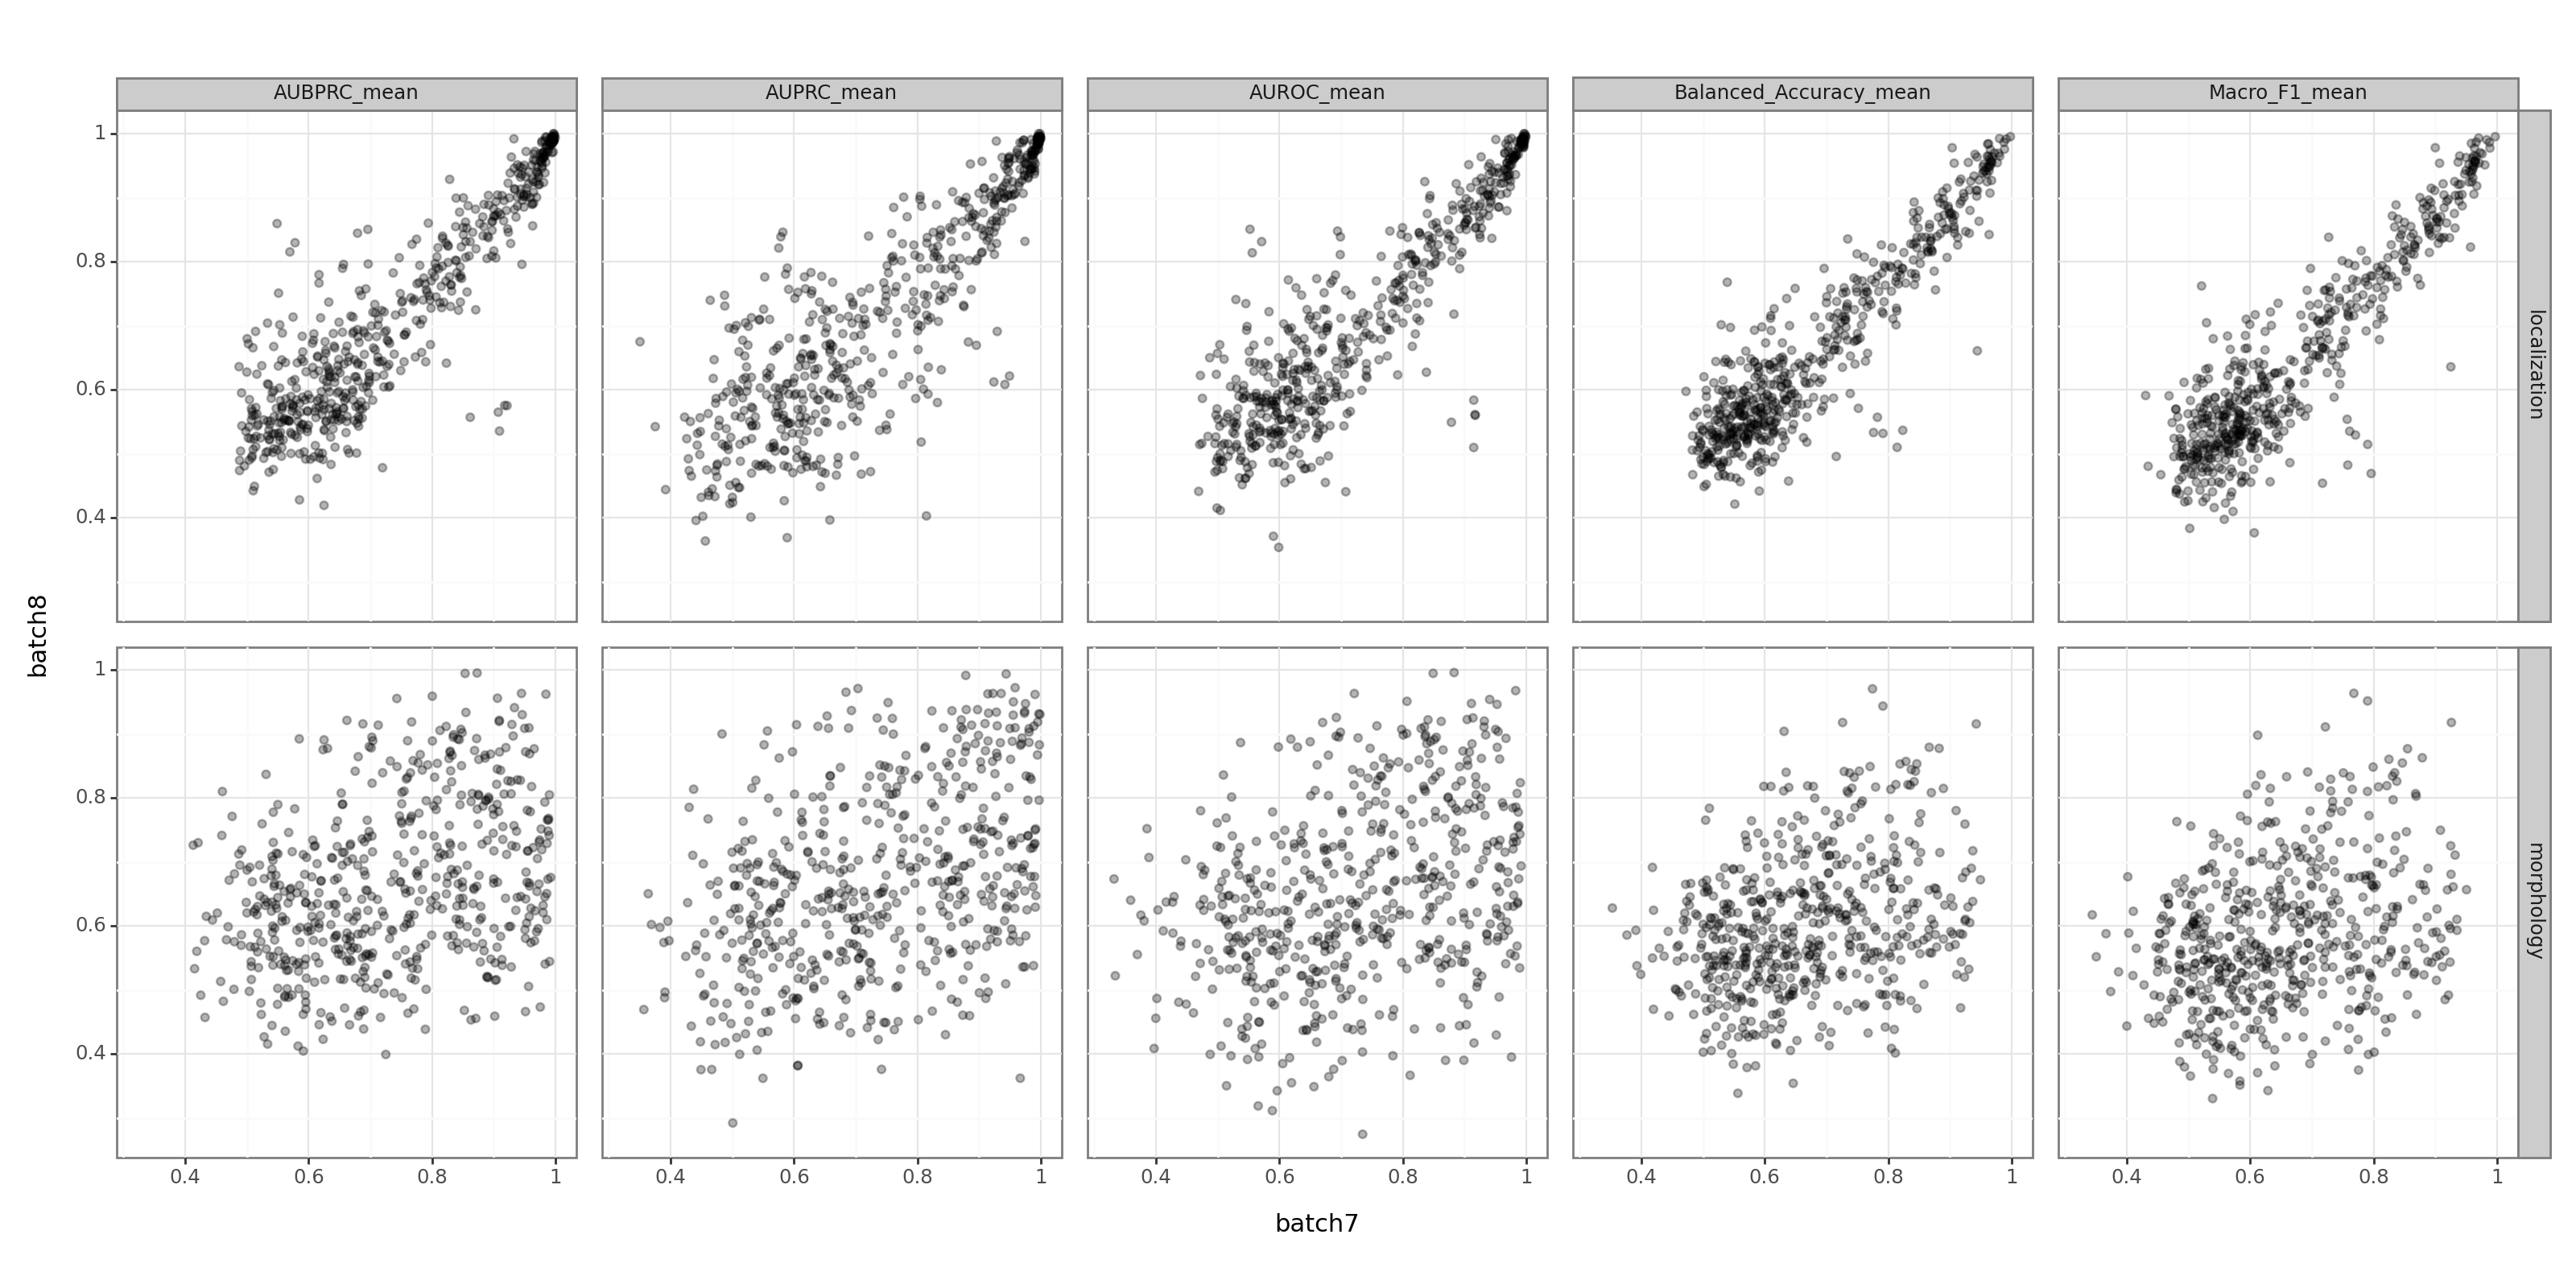

<Figure Size: (1600 x 800)>

In [14]:
plotnine.options.figure_size = (16, 8)
(
    ggplot(
        metrics_summary.filter(pl.col("Metric").str.contains("mean")),
        aes(x="batch7", y="batch8"),
    )
    + geom_point(alpha=0.3)
    + theme_bw()
    + facet_grid("Classifier_type ~ Metric", "free")
)